In [ ]:
import torch
import json
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import pickle
import os
from neural_concept_binder import NeuralConceptBinder
import utils_ncb as utils_bnr
from torchvision import transforms
from argparse import Namespace
from datetime import datetime
import sglang as sgl
from sglang.srt.constrained import build_regex_from_object
from enum import Enum
from pydantic import BaseModel
from copy import deepcopy

# load Object Detection
sam2_checkpoint = "checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=torch.device("cuda"))
predictor = SAM2ImagePredictor(sam2_model)

# prepare ncb retrieval corpus
ncb_seed = 1
with open(
    f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/block_concept_dicts.pkl", "rb"
) as f:
    block_concepts = pickle.load(f)
with open(f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/all_img_locs.pkl", "rb") as f:
    all_img_locs = pickle.load(f)

# setup ncb
utils_bnr.set_seed(0)
args = Namespace(
    seed=0,
    batch_size=20,
    num_workers=0,
    image_size=128,
    image_channels=3,
    data_path="data/*.png",
    perc_imgs=1.0,
    log_path="../logs/",
    checkpoint_path=f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/best_model.pt",
    model_type="ncb",
    use_dp=False,
    name=datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
    num_categories=3,
    clf_type="dt",
    lr_dvae=0.0003,
    lr_enc=0.0001,
    lr_dec=0.0003,
    lr_warmup_steps=30000,
    lr_half_life=250000,
    clip=0.05,
    epochs=500,
    num_iterations=3,
    num_slots=4,
    num_blocks=16,
    cnn_hidden_size=512,
    slot_size=2048,
    mlp_hidden_size=192,
    num_prototypes=64,
    temp=1.0,
    temp_step=False,
    vocab_size=4096,
    num_decoder_layers=8,
    num_decoder_heads=4,
    d_model=192,
    dropout=0.1,
    tau_start=1.0,
    tau_final=0.1,
    tau_steps=30000,
    lr=0.01,
    binarize=False,
    attention_codes=False,
    retrieval_corpus_path=f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/block_concept_dicts.pkl",
    deletion_dict_path=None,
    merge_dict_path=None,
    retrieval_encs="proto-exem",
    majority_vote=False,
    topk=5,
    thresh_attn_obj_slots=0.98,
    thresh_count_obj_slots=1,  # -1 for all
    device="cuda",
)
utils_bnr.set_seed(0)
if args.model_type == "ncb":
    ncb_model = NeuralConceptBinder(args)
else:
    raise ValueError(f"Model type {args.model_type} not handled in this script!")
ncb_model.to(args.device)
ncb_model.eval()
torch.set_grad_enabled(True)

Loading retrieval corpus from /app/ncb/CLEVR-4/retbind_seed_1/block_concept_dicts.pkl ...

Number of concepts per block: 
[120, 5, 4, 5, 9, 2, 6, 8, 45, 213, 5, 189, 3, 4, 2, 239]

loaded .../app/ncb/CLEVR-4/retbind_seed_1/best_model.pt


In [ ]:
# launch vlm server in separate terminal via:
# python -m sglang.launch_server --model-path lmms-lab/llava-onevision-qwen2-7b-ov --port 30000 --host 0.0.0.0 --chat-template chatml-llava --log-level warn

# after starting server somewhere else
from sglang.utils import wait_for_server

wait_for_server("http://localhost:30000")
sgl.set_default_backend(sgl.RuntimeEndpoint("http://localhost:30000"))

In [3]:
# define structured output
class color(str, Enum):
    brown = "brown"
    blue = "blue"
    yellow = "yellow"
    gray = "gray"
    green = "green"
    cyan = "cyan"
    red = "red"
    purple = "purple"


class shape(str, Enum):
    sphere = "sphere"
    cylinder = "cylinder"
    cube = "cube"


class material(str, Enum):
    rubber = "rubber"
    metal = "metal"


class size(str, Enum):
    small = "small"
    medium = "medium"
    large = "large"


class object_properties(BaseModel):
    color: color
    shape: shape
    material: material
    size: size

In [ ]:
# declare dicts for dynamic programming
raw_encodings_table = dict()
encodings_table = dict()

In [ ]:
# methods for ncb, attribute retrieval, showing images
def get_negative_point(masks: np.ndarray, neighbor_radius=5):
    mask = masks[0]
    height, width = mask.shape
    offset = 10

    for y in range(offset, height - offset):  # Avoid edges
        for x in range(offset, width - offset):
            # Extract the 5x5 neighborhood centered at (y, x)
            neighborhood = mask[
                y - neighbor_radius : y + neighbor_radius + 1,
                x - neighbor_radius : x + neighbor_radius + 1,
            ]

            # Check if all values in the neighborhood are False
            if np.all(neighborhood == False):
                return (
                    x,
                    y,
                )  # Return the first coordinate (x, y) that satisfies the condition

    raise RuntimeError(
        "Could not find a pixel with an entirely False neighborhood. Reduce neighbor_radius"
    )


def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = np.mean(foreground_pixels[:, 0])  # Mean of y-coordinates (rows)
    mean_x = np.mean(foreground_pixels[:, 1])  # Mean of x-coordinates (columns)

    return (mean_x, mean_y)  # Return the (x, y) coordinates of the centroid


def reduce_attribute_dict(ad: dict) -> dict:
    reduced_dict = {}
    for key, value_list in ad.items():
        reference_value = value_list[0]
        varying_attribute = False
        for value in value_list:
            if value != reference_value:
                # TODO: introduce LLM back when ready
                # if are_concepts_similar(key, reference_value, value):
                #     reference_value = get_common_name(key, reference_value, value)
                # else:
                varying_attribute = True
                break
        if not varying_attribute:
            reduced_dict[key] = reference_value

    return reduced_dict


def approximate_position(x, y, image_width=128, image_height=128):
    cell_width = image_width // 3
    cell_height = image_height // 3

    # Classify the x coordinate (left, center, right)
    if x < cell_width:
        horizontal_position = "left"
    elif x < 2 * cell_width:
        horizontal_position = "center"
    else:
        horizontal_position = "right"

    # Classify the y coordinate (top, center, bottom)
    if y < cell_height:
        vertical_position = "top"
    elif y < 2 * cell_height:
        vertical_position = "center"
    else:
        vertical_position = "bottom"

    # Return the bin position
    return horizontal_position, vertical_position


def get_position_attribute(image_filenames: list[str]):
    # get position attribute
    horizontal_position_list = []
    vertical_position_list = []
    for image_name in image_filenames:
        image = Image.open(image_name)
        image = np.array(image.convert("RGB"))
        H, W, C = image.shape
        predictor.set_image(image)

        # select background
        input_box = np.array([0, 0, H, W])
        background_masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        object_point = get_negative_point(background_masks)
        object_point = np.array([[object_point[0], object_point[1]]])
        object_label = np.array([1])

        object_masks, scores, logits = predictor.predict(
            point_coords=object_point, point_labels=object_label, multimask_output=False
        )
        mask_center = mean_center_of_mask(object_masks[0])
        horizintal_pos, vertical_pos = approximate_position(
            *mask_center, image_height=H, image_width=W
        )
        horizontal_position_list.append(horizintal_pos)
        vertical_position_list.append(vertical_pos)

    return horizontal_position_list, vertical_position_list


def get_example_filenames_from_block_cluster(
    block_id: int, cluster_id: int, num_examples: int = 10
):
    assert cluster_id <= len(
        block_concepts[block_id]["prototypes"]["ids"]
    ), "Cluster id exceeds number of clusters."
    num_examples = min(
        len(block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id]),
        num_examples,
    )

    filepaths = []
    base_path = "/app/clevr_images/train/images/"

    for i in range(num_examples):
        id = block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id][i]
        path = os.path.join(base_path, os.path.basename(all_img_locs[id]))
        filepaths.append(path)

    return filepaths


def get_ncb_encoding(img_fn: str, plot=False):
    # TODO: Why do I need to set a seed here for consistent results?
    utils_bnr.set_seed(0)

    img = Image.open(img_fn)
    img.thumbnail((128, 128))
    transform = transforms.Compose(
        [
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
        ]
    )
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension

    codes, probs, slots, attns_vis, attns = ncb_model.encode(img_tensor)

    if plot:
        plot_attention_masks(img, img_tensor, attns, attns_vis)
        print(codes.numpy().astype(int))

    return codes, probs, slots, attns_vis, attns
    # codes.to('cpu').numpy().astype(int)#.flatten()


def show_images(image_filenames: list[str]):
    fig, axs = plt.subplots(1, len(image_filenames))
    for i in range(len(image_filenames)):
        axs[i].imshow(imread(image_filenames[i]))
        axs[i].axis("off")
    plt.show()
    plt.close()


def show_image(image_filename: str):
    plt.imshow(imread(image_filename))
    plt.show()
    plt.close()


def get_attributes_dict_from_images(image_filenames: list[str]):
    # get attributes except for position
    response_dicts = [object_description_gen(fp) for fp in image_filenames]
    assembled_dict = {key: [] for key in response_dicts[0].keys()}
    for rd in response_dicts:
        for key, value in rd.items():
            assembled_dict[key].append(value)

    return assembled_dict


@sgl.function
def object_description(s, image_fp: str):
    s += sgl.user(
        sgl.image(image_fp)
        + "Give me a description about the object in the image in the JSON format.\n"
    )
    s += sgl.gen(
        "object description",
        max_tokens=128,
        temperature=0.2,
        regex=build_regex_from_object(object_properties),  # Requires pydantic >= 2.0
    )


def object_description_gen(image_fp: str):
    state = object_description.run(image_fp)
    response = state.text()
    start_index = response.find("{")
    return json.loads(response[start_index:])


def describe_encodings(ncb_encodings, num_examples=10):
    encoding_dicts = []

    for enc in ncb_encodings:
        block_encodings = []
        for block_id, cluster_id in enumerate(enc):
            block_encodings.append(
                dynamic_encoding_lookup(block_id, cluster_id, num_examples)[0]
            )

        encoding_dicts.append(block_encodings)

    return encoding_dicts


# returns the encoding description if available, else None
def lookup_encoding_table(block_id: int, cluster_id: int):
    if not encodings_table.get(block_id, False):
        encodings_table[block_id] = dict()
        raw_encodings_table[block_id] = dict()
    return encodings_table[block_id].get(cluster_id, None), raw_encodings_table[
        block_id
    ].get(cluster_id, None)


def dynamic_encoding_lookup(block_id: int, cluster_id: int, num_examples=10):
    reduced_encoding, raw_encoding = lookup_encoding_table(block_id, cluster_id)
    if reduced_encoding is not None:
        return reduced_encoding, raw_encoding
    else:
        image_filenames = get_example_filenames_from_block_cluster(
            block_id, cluster_id, num_examples=num_examples
        )
        attribute_dict = get_attributes_dict_from_images(image_filenames)
        horizontal_position_list, vertical_position_list = get_position_attribute(
            image_filenames
        )
        attribute_dict["horizontal position"] = horizontal_position_list
        attribute_dict["vertical position"] = vertical_position_list
        raw_attribute_dict = deepcopy(attribute_dict)
        raw_encodings_table[block_id][cluster_id] = raw_attribute_dict
        reduced_attribute_dict = reduce_attribute_dict(attribute_dict)
        encodings_table[block_id][cluster_id] = reduced_attribute_dict
        return reduced_attribute_dict, raw_attribute_dict


def show_examples_retrieve_attributes(block_id: int, cluster_id: int, num_examples=10):
    image_filenames = get_example_filenames_from_block_cluster(
        block_id, cluster_id, num_examples=num_examples
    )
    show_images(image_filenames)

    reduced_attribute_dict, raw_attribute_dict = dynamic_encoding_lookup(
        block_id, cluster_id, num_examples
    )

    # reduce attribute dict
    print(f"Raw attribute dict:\t{raw_attribute_dict}")
    print(f"Reduced attribute dict:\t{reduced_attribute_dict}")
    return reduced_attribute_dict, raw_attribute_dict


def compare_ncb_encodings(encoding_1, encoding_2, num_examples=10):
    for i in range(len(encoding_1)):
        if encoding_1[i] != encoding_2[i]:
            print("------------------------------------")
            print(f"DIFFERENCE IN BLOCK {i}")
            print(f"Cluster {encoding_1[i]}")
            show_examples_retrieve_attributes(
                i, encoding_1[i], num_examples=num_examples
            )
            print(f"Cluster {encoding_2[i]}")
            show_examples_retrieve_attributes(
                i, encoding_2[i], num_examples=num_examples
            )


def plot_attention_masks(img, img_tensor, attns, attns_vis):
    # assume we only got one mask
    my_attns = attns.cpu().detach().numpy().squeeze(0).squeeze(0).squeeze(0)

    my_vis = attns_vis.cpu().detach().numpy().squeeze(0).squeeze(0)
    my_vis = np.transpose(my_vis, (1, 2, 0))

    img_tensor = img_tensor.cpu().detach().numpy().squeeze(0)
    img_tensor = np.transpose(img_tensor, (1, 2, 0))

    _, axs = plt.subplots(1, 4, figsize=(12, 12))
    axs[0].imshow(img)
    axs[0].set_title("Downsized input image")
    axs[1].imshow(img_tensor)
    axs[1].set_title("Input image tensor")
    axs[2].imshow(my_attns, cmap="grey")
    axs[2].set_title("Attention weights")
    axs[3].imshow(my_vis)
    axs[3].set_title("Attention weights * input tensor")
    plt.show()
    plt.close()

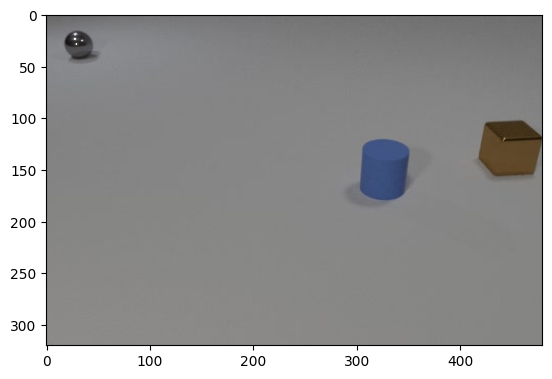

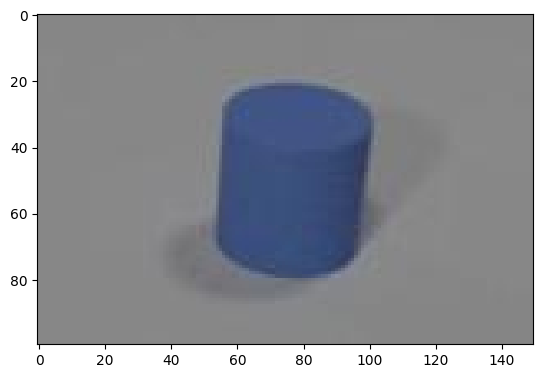

In [ ]:
# ignore if you don't want to work with the zoomed in image
# show_image("/app/ncb/edited_video_10000/video_frames/00020.jpg")
# img = Image.open("/app/ncb/edited_video_10000/video_frames/00020.jpg")
# img.crop((250, 100, 400, 200)).save("/app/ncb/cropped_test_image.jpg")
# show_image("/app/ncb/cropped_test_image.jpg")

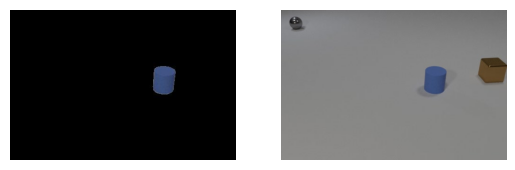

{'color': ['blue', 'blue'], 'shape': ['cylinder', 'cylinder'], 'material': ['rubber', 'rubber'], 'size': ['small', 'small'], 'horizontal position': ['right', 'center'], 'vertical position': ['center', 'center']}


In [ ]:
# image_filenames = ["/app/clevr_images/train/images/CLEVR_4_classid_0_000456.png", "/app/clevr_images/train/images/CLEVR_4_classid_0_002948.png"]
image_filenames = ["/app/ncb/edited_video_10000/cropped_images/00020.jpg", "/app/ncb/edited_video_10000/video_frames/00020.jpg"]
show_images(image_filenames)
response = get_attributes_dict_from_images(image_filenames)
horizontal_position_list, vertical_position_list = get_position_attribute(image_filenames)
response["horizontal position"] = horizontal_position_list
response["vertical position"] = vertical_position_list

print(response)

In [ ]:
# define base paths for video frames
blackened_base_path = "/app/ncb/edited_video_10000/cropped_images"
unedited_base_path = "/app/ncb/edited_video_10000/video_frames"
base_path = blackened_base_path
# frame_names = ["00000.jpg", "00020.jpg", "00040.jpg", "00060.jpg", "00080.jpg", "00100.jpg", "00120.jpg"]
frame_names = sorted(os.listdir(base_path))
frame_names = [os.path.join(base_path, frame_name) for frame_name in frame_names]

ncb_encodings = np.array(
    [get_ncb_encoding(fn, plot=False)[0].flatten() for fn in frame_names]
).astype(int)

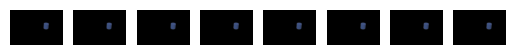

[[ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  3]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  3]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  3]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  1]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  1]
 [ 0  3  3  0  7  0  1  6  5 57  2 15  2  1  0  1]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  1]
 [ 0  3  3  0  7  0  0  6  5 57  2 15  2  1  0  1]]


In [166]:
# plot images with their ncb encodings
show_images(frame_names[0:8:1])
print(ncb_encodings[0:8:1])

In [ ]:
# visualize encoding differences
print(ncb_encodings[0])
print(ncb_encodings[1])
compare_ncb_encodings(ncb_encodings[1], ncb_encodings[2])

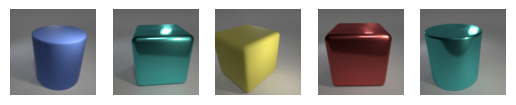

Raw attribute dict:	{'color': ['blue', 'cyan', 'yellow', 'red', 'cyan', 'gray', 'brown', 'yellow', 'brown', 'purple'], 'shape': ['cylinder', 'cube', 'cube', 'cube', 'cylinder', 'cylinder', 'cylinder', 'cube', 'cylinder', 'cylinder'], 'material': ['metal', 'metal', 'rubber', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'rubber'], 'size': ['large', 'large', 'large', 'large', 'large', 'large', 'large', 'large', 'large', 'large'], 'horizontal position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'top', 'top', 'center', 'center', 'top', 'center']}
Reduced attribute dict:	{'size': 'large', 'horizontal position': 'center'}


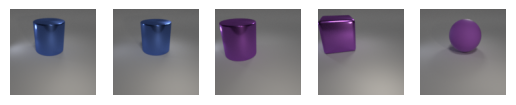

Raw attribute dict:	{'color': ['blue', 'blue', 'purple', 'purple', 'purple', 'purple', 'blue', 'blue', 'purple', 'purple'], 'shape': ['cylinder', 'cylinder', 'cylinder', 'cube', 'sphere', 'cylinder', 'cube', 'cube', 'sphere', 'cylinder'], 'material': ['metal', 'metal', 'metal', 'metal', 'rubber', 'metal', 'metal', 'metal', 'rubber', 'metal'], 'size': ['large', 'large', 'small', 'large', 'large', 'large', 'large', 'large', 'large', 'large'], 'horizontal position': ['center', 'center', 'left', 'left', 'center', 'center', 'right', 'right', 'center', 'left'], 'vertical position': ['top', 'top', 'center', 'top', 'top', 'top', 'top', 'top', 'center', 'center']}
Reduced attribute dict:	{}


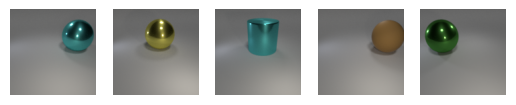

Raw attribute dict:	{'color': ['cyan', 'yellow', 'cyan', 'brown', 'green', 'red', 'cyan', 'brown', 'green', 'blue'], 'shape': ['sphere', 'sphere', 'cylinder', 'sphere', 'sphere', 'sphere', 'cylinder', 'sphere', 'cylinder', 'sphere'], 'material': ['metal', 'metal', 'metal', 'rubber', 'metal', 'rubber', 'rubber', 'rubber', 'rubber', 'rubber'], 'size': ['large', 'large', 'large', 'large', 'small', 'large', 'large', 'large', 'small', 'large'], 'horizontal position': ['right', 'center', 'center', 'right', 'left', 'right', 'left', 'left', 'right', 'left'], 'vertical position': ['top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top']}
Reduced attribute dict:	{'vertical position': 'top'}


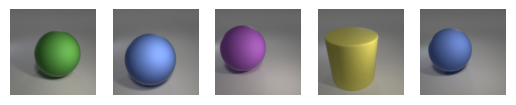

Raw attribute dict:	{'color': ['green', 'blue', 'purple', 'yellow', 'blue'], 'shape': ['sphere', 'sphere', 'sphere', 'cylinder', 'sphere'], 'material': ['rubber', 'metal', 'rubber', 'rubber', 'rubber'], 'size': ['large', 'large', 'large', 'large', 'large'], 'horizontal position': ['center', 'center', 'left', 'center', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'size': 'large', 'vertical position': 'center'}


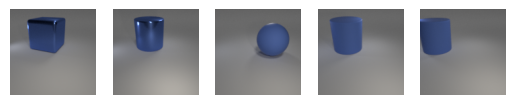

Raw attribute dict:	{'color': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'], 'shape': ['cube', 'cylinder', 'sphere', 'cylinder', 'cylinder', 'sphere', 'cylinder', 'sphere', 'cube', 'sphere'], 'material': ['metal', 'metal', 'rubber', 'rubber', 'rubber', 'rubber', 'metal', 'rubber', 'metal', 'rubber'], 'size': ['large', 'large', 'large', 'large', 'large', 'large', 'large', 'large', 'large', 'large'], 'horizontal position': ['center', 'center', 'right', 'center', 'left', 'left', 'center', 'center', 'left', 'center'], 'vertical position': ['top', 'top', 'center', 'top', 'top', 'top', 'top', 'center', 'top', 'top']}
Reduced attribute dict:	{'color': 'blue', 'size': 'large'}


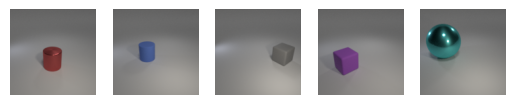

Raw attribute dict:	{'color': ['red', 'blue', 'gray', 'purple', 'cyan', 'gray', 'gray', 'green', 'cyan', 'red'], 'shape': ['cylinder', 'cylinder', 'cube', 'cube', 'sphere', 'cylinder', 'sphere', 'cube', 'cube', 'sphere'], 'material': ['metal', 'rubber', 'rubber', 'rubber', 'metal', 'rubber', 'metal', 'rubber', 'metal', 'metal'], 'size': ['small', 'small', 'small', 'small', 'large', 'small', 'small', 'small', 'small', 'small'], 'horizontal position': ['center', 'center', 'right', 'left', 'left', 'right', 'right', 'center', 'left', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'vertical position': 'center'}


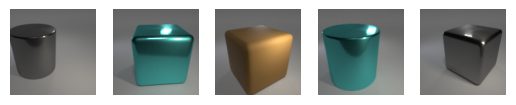

Raw attribute dict:	{'color': ['gray', 'cyan', 'brown', 'cyan', 'gray'], 'shape': ['cylinder', 'cube', 'cube', 'cylinder', 'cube'], 'material': ['metal', 'metal', 'metal', 'metal', 'metal'], 'size': ['large', 'large', 'large', 'large', 'large'], 'horizontal position': ['left', 'center', 'center', 'center', 'center'], 'vertical position': ['top', 'center', 'top', 'top', 'top']}
Reduced attribute dict:	{'material': 'metal', 'size': 'large'}


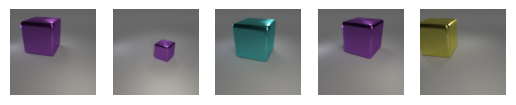

Raw attribute dict:	{'color': ['purple', 'purple', 'cyan', 'purple', 'yellow', 'gray', 'purple', 'brown', 'purple', 'gray'], 'shape': ['cube', 'cube', 'cube', 'cube', 'cube', 'cube', 'cube', 'cube', 'cube', 'cube'], 'material': ['metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal', 'metal'], 'size': ['large', 'small', 'large', 'large', 'small', 'small', 'large', 'large', 'large', 'small'], 'horizontal position': ['center', 'center', 'center', 'center', 'left', 'center', 'left', 'center', 'left', 'left'], 'vertical position': ['top', 'center', 'center', 'top', 'top', 'center', 'center', 'top', 'center', 'center']}
Reduced attribute dict:	{'shape': 'cube', 'material': 'metal'}


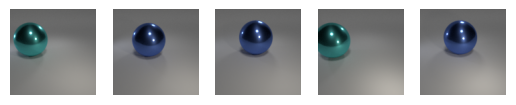

Raw attribute dict:	{'color': ['cyan', 'blue', 'blue', 'cyan', 'blue', 'cyan', 'blue', 'blue', 'blue', 'blue'], 'shape': ['sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'cube', 'sphere', 'cube', 'sphere', 'cylinder'], 'material': ['metal', 'metal', 'metal', 'metal', 'metal', 'rubber', 'rubber', 'rubber', 'rubber', 'rubber'], 'size': ['large', 'large', 'large', 'small', 'large', 'large', 'large', 'large', 'large', 'large'], 'horizontal position': ['left', 'center', 'center', 'left', 'center', 'left', 'right', 'left', 'center', 'left'], 'vertical position': ['center', 'center', 'top', 'center', 'top', 'center', 'center', 'center', 'top', 'center']}
Reduced attribute dict:	{}


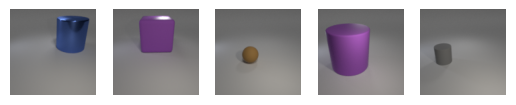

Raw attribute dict:	{'color': ['blue', 'purple', 'brown', 'purple', 'gray'], 'shape': ['cylinder', 'cube', 'sphere', 'cylinder', 'cylinder'], 'material': ['metal', 'rubber', 'rubber', 'rubber', 'rubber'], 'size': ['large', 'large', 'small', 'large', 'small'], 'horizontal position': ['right', 'center', 'center', 'center', 'left'], 'vertical position': ['top', 'top', 'center', 'center', 'center']}
Reduced attribute dict:	{}


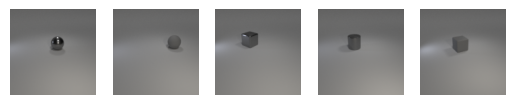

Raw attribute dict:	{'color': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'], 'shape': ['sphere', 'sphere', 'cube', 'cylinder', 'cube', 'sphere', 'sphere', 'sphere', 'sphere', 'cylinder'], 'material': ['metal', 'rubber', 'metal', 'metal', 'rubber', 'metal', 'metal', 'rubber', 'metal', 'rubber'], 'size': ['small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small'], 'horizontal position': ['center', 'right', 'center', 'center', 'center', 'right', 'left', 'right', 'center', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'color': 'gray', 'size': 'small', 'vertical position': 'center'}


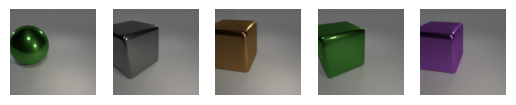

Raw attribute dict:	{'color': ['green', 'gray', 'brown', 'green', 'purple'], 'shape': ['sphere', 'cube', 'cube', 'cube', 'cube'], 'material': ['metal', 'metal', 'metal', 'metal', 'metal'], 'size': ['large', 'large', 'large', 'large', 'large'], 'horizontal position': ['left', 'left', 'left', 'left', 'left'], 'vertical position': ['center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'material': 'metal', 'size': 'large', 'horizontal position': 'left', 'vertical position': 'center'}


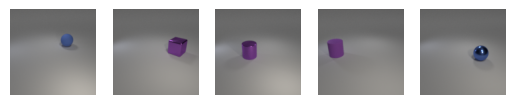

Raw attribute dict:	{'color': ['blue', 'purple', 'purple', 'purple', 'blue', 'blue', 'purple', 'purple', 'purple', 'blue'], 'shape': ['sphere', 'cube', 'cylinder', 'cylinder', 'sphere', 'cylinder', 'cube', 'sphere', 'cube', 'sphere'], 'material': ['rubber', 'metal', 'metal', 'rubber', 'metal', 'rubber', 'rubber', 'rubber', 'rubber', 'metal'], 'size': ['small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small'], 'horizontal position': ['right', 'right', 'center', 'left', 'right', 'center', 'right', 'center', 'right', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'size': 'small', 'vertical position': 'center'}


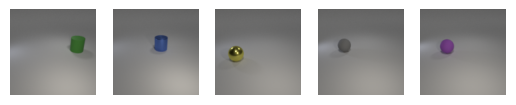

Raw attribute dict:	{'color': ['green', 'blue', 'yellow', 'gray', 'purple', 'green', 'green', 'green', 'red', 'yellow'], 'shape': ['cylinder', 'cylinder', 'sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'cylinder', 'sphere', 'sphere'], 'material': ['rubber', 'metal', 'metal', 'rubber', 'rubber', 'metal', 'rubber', 'metal', 'rubber', 'rubber'], 'size': ['small', 'small', 'small', 'small', 'small', 'large', 'small', 'small', 'small', 'small'], 'horizontal position': ['right', 'center', 'left', 'left', 'left', 'right', 'left', 'center', 'right', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'top', 'center', 'center']}
Reduced attribute dict:	{}


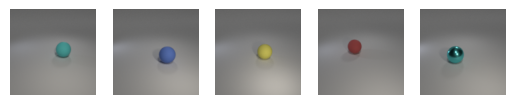

Raw attribute dict:	{'color': ['cyan', 'blue', 'yellow', 'red', 'cyan', 'cyan', 'yellow', 'cyan', 'blue', 'purple'], 'shape': ['sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'sphere', 'cylinder', 'sphere'], 'material': ['rubber', 'rubber', 'rubber', 'rubber', 'metal', 'rubber', 'metal', 'rubber', 'metal', 'rubber'], 'size': ['small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small'], 'horizontal position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'right', 'center'], 'vertical position': ['center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{'size': 'small', 'vertical position': 'center'}


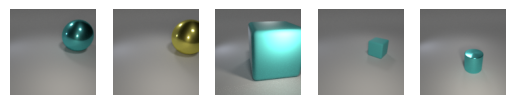

Raw attribute dict:	{'color': ['cyan', 'yellow', 'cyan', 'cyan', 'cyan', 'yellow'], 'shape': ['sphere', 'sphere', 'cube', 'cube', 'cylinder', 'sphere'], 'material': ['metal', 'metal', 'metal', 'rubber', 'metal', 'rubber'], 'size': ['large', 'large', 'large', 'small', 'small', 'small'], 'horizontal position': ['right', 'right', 'right', 'right', 'center', 'right'], 'vertical position': ['top', 'top', 'center', 'center', 'center', 'center']}
Reduced attribute dict:	{}


In [ ]:
# visualize components of an encoding vector
encoding_to_look_at = ncb_encodings[0]

for i in range(len(encoding_to_look_at)):
    show_examples_retrieve_attributes(i, encoding_to_look_at[i], num_examples=5)

In [ ]:
# use VLM to get attributes from NCB encodings
attribute_dicts = describe_encodings(ncb_encodings)

In [ ]:
# methods for dict processing
from collections import defaultdict


def aggregate_dicts(attribute_dicts: list[list[dict]]) -> list[dict]:
    dict_list = []
    for ad in attribute_dicts:

        attribute_counts = defaultdict(lambda: defaultdict(int))
        for entry in ad:
            for key, value in entry.items():
                attribute_counts[key][value] += 1

        attribute_counts = {k: dict(v) for k, v in attribute_counts.items()}
        filtered_attribute_counts = {
            key: value
            for key, value in attribute_counts.items()
            if sum(value.values()) > 1
        }
        dict_list.append(filtered_attribute_counts)

    return dict_list


# chooses the maximum element for each dict key. For multiple max values, chooses first one
def choose_maximum_value(attribute_dicts: list[dict]):
    for ad in attribute_dicts:
        for key in ad.keys():
            ad[key] = max(ad[key], key=ad[key].get)

    return attribute_dicts


# Press attribute dicts into the same form as gt
def format_dicts(attributes: list[dict], format_keys: list[str]) -> list[dict]:
    formatted_list = []
    for att in attributes:
        formatted_dict = dict()
        for key in format_keys:
            formatted_dict[key] = att.get(key, None)
        formatted_list.append(formatted_dict)

    return formatted_list

In [ ]:
# combine attribute dicts from all blocks for each frame
aggregated_attributes = aggregate_dicts(attribute_dicts)
print("aggregated dicts:")
for aa in aggregated_attributes:
    print(aa)

# choose most frequent feature for each attribute
max_dicts = choose_maximum_value(aggregated_attributes)
print("max dicts:")
for md in max_dicts:
    print(md)

# Cut size etc., fill missing values with None
formatted_dicts = format_dicts(max_dicts, ["color", "material", "shape"])
print("formatted dicts:")
for fd in formatted_dicts:
    print(fd)

aggregated dicts:
{'size': {'large': 5, 'small': 3}, 'horizontal position': {'center': 1, 'left': 1}, 'vertical position': {'top': 1, 'center': 6}, 'color': {'blue': 1, 'gray': 1}, 'material': {'metal': 3}}
{'size': {'large': 5, 'small': 3}, 'horizontal position': {'center': 1, 'left': 1}, 'vertical position': {'top': 1, 'center': 6}, 'color': {'blue': 1, 'gray': 1}, 'material': {'metal': 3}}
{'size': {'large': 5, 'small': 3}, 'horizontal position': {'center': 1, 'left': 1}, 'vertical position': {'top': 1, 'center': 6}, 'color': {'blue': 1, 'gray': 1}, 'material': {'metal': 3}}
{'size': {'large': 5, 'small': 3}, 'horizontal position': {'center': 1, 'left': 1}, 'vertical position': {'top': 1, 'center': 6}, 'color': {'blue': 1, 'gray': 1}, 'material': {'metal': 3}}
{'size': {'large': 5, 'small': 3}, 'horizontal position': {'center': 1, 'left': 1}, 'vertical position': {'top': 1, 'center': 6}, 'color': {'blue': 1, 'gray': 1}, 'material': {'metal': 3}}
{'size': {'large': 5, 'small': 3}, 'h

In [ ]:
# methods for assessing resulting attributes dicts
# assume you got two dicts with the same structure, check how many entries are the same
def compare_attribute_dicts(dict1: dict, dict2: dict):
    return np.mean([dict1[key] == dict2[key] for key in dict1])


def dict_accuracy_over_video(attribute_dicts: list[dict], gt: dict):
    return np.mean([compare_attribute_dicts(gt, ad) for ad in attribute_dicts])


def plot_attribute_correctness(formatted_dicts: list[dict], gt: dict):
    print(f"ground truth: {gt}")

    n, m = len(formatted_dicts), len(gt.keys())
    time = np.arange(n)
    fig, ax = plt.subplots(figsize=(10, 6))

    for t in time:
        y = 0
        for key in gt.keys():
            color = "green" if formatted_dicts[t][key] == gt[key] else "red"
            ax.barh(y, 1, left=t, color=color, edgecolor="black", height=0.75)
            y += 1

    # Formatting
    ax.set_yticks(range(m))
    ax.set_yticklabels([f"{key}" for key in gt.keys()])
    ax.set_xlabel("frame")
    ax.set_title("Correctness of retrieved attributes over time")
    ax.invert_yaxis()  # Optional: invert y-axis for better readability

    plt.tight_layout()
    plt.show()

Overall attribute accuracy: 0.33333333333333326
ground truth: {'color': 'blue', 'material': 'rubber', 'shape': 'cylinder'}


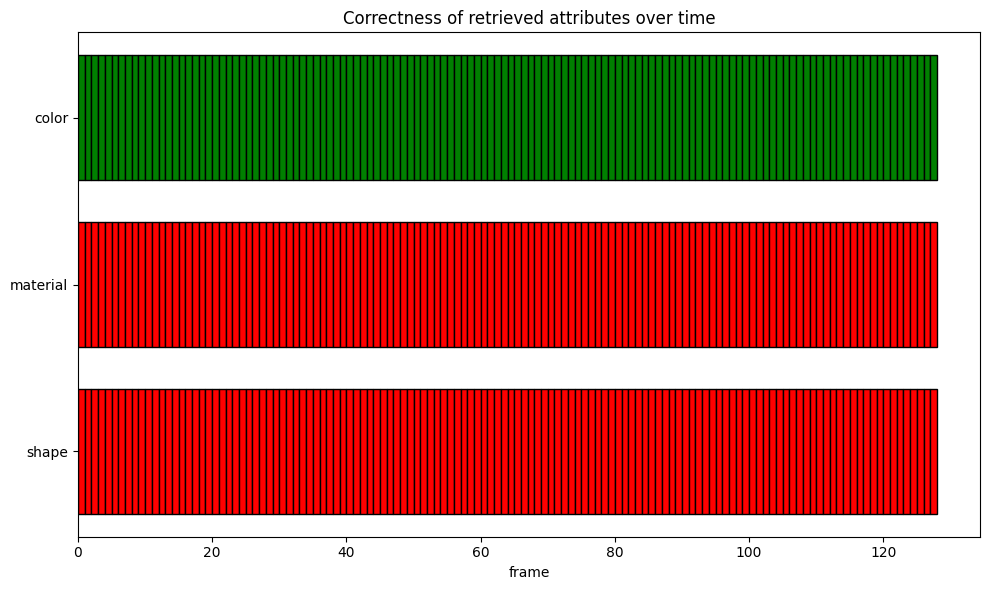

In [ ]:
# plot correctness of attributes for video_10000
gt = {"color": "blue", "material": "rubber", "shape": "cylinder"}
print(f"Overall attribute accuracy: {dict_accuracy_over_video(formatted_dicts, gt)}")
plot_attribute_correctness(formatted_dicts, gt)